In [1]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import random as rd
import matplotlib.pyplot as plt
import gudhi as gd

# Functions

### Generating Random Point Cloud

In [2]:
def gen_points(N=5):
    # randomly generates some points in unit square
    return np.array([[rd.random(),rd.random()] for i in range(N)])


### Sublist Function

In [3]:
def k_sub(lst,k=0):
    # takes list containing a sequence of sublists and 
    # returns list of the first elements of each sublist
    return [item[k] for item in lst]

### Plot Point Cloud

In [4]:


def plot_complex(vertices, alpha=1):
    # displays NON_PERIODIC 2-dim complex
    # takes vertices as numpy array and non-empy simplex tree and plots it
    
    alpha_complex = gd.AlphaComplex(vertices.reshape(-1,2))
    simplex_tree = alpha_complex.create_simplex_tree(max_alpha_square=alpha)

    filt = k_sub(simplex_tree.get_filtration())
    filt.sort(key = len)
    
    # cut into different dimensions of simplex
    # dimension is upper bounded by 2
    simp_0 = []
    simp_1 = []
    simp_2 = []
    cut = 0
    dim = 0
    
    
    for simp in filt:
        if len(simp) == 1:
            simp_0.append(simp)
        if len(simp) == 2:
            simp_1.append(simp)
        if len(simp) == 3:
            simp_2.append(simp)
   
    # plot points
    plt.scatter(vertices[:,0],vertices[:,1], color='black')
    
    # plot lines
    for [i,j] in simp_1:
        plt.plot((vertices[i,0],vertices[j,0]), (vertices[i,1],vertices[j,1]), color='#527da2')
    
    # plot triangles
    for [i,j,k] in simp_2:
        plt.fill((vertices[i,0],vertices[j,0],vertices[k,0]), (vertices[i,1],vertices[j,1],vertices[k,1]), color='#fcb73d')
    

    
    # plot unit square
    # (x1,x2), (y1,y2)
    plt.plot((0,0,1,1,0), (0,1,1,0,0), color = 'black')
    
    # plot transparent layer to grey out the repeating tiles, if there are any
    # this assumes we are in the periodic case with a right angle unit square repetition 
    plt.fill((-1,2,2,1,1,0,0,2,2,-1,-1), (2,2,0,0,1,1,0,0,-1,-1,2), color='white',alpha=0.8)
    
    plt.gca().set_aspect('equal')

### Duplicatig Point Cloud to 9x9 Tile

In [5]:
def torus_copy(points, a=1,b=1):
    # takes point set on unit square and creates 8 copies surrounding it
    # Alternatively not unit square, but rectangle, sides given by a, b
    # returns original points and offset copies of them
    
    N = np.shape(points)[0]
    new_points = np.zeros((9,N,2)) # 3x3 square numbered from left top to bottom right, Z-pattern
    #new_points[5,:,:] = points
    
    i = 0 
    for x in [-a,0,a]:
        for y in [-b,0,b]:
            transl = np.array([[x,y] for counter in range(N)])
            new_points[i,:,:] = points + transl
            i += 1
            
    return new_points.reshape(-1,2)

 
# Origially I thought it was smart to store which square we are in by setting a third coordinate
# However, at this point I am not using it, which is why I use reshape at the very end.


### Calculate Periodic Filtration from Duplicated Point Cloud

In [6]:
def periodic_filtration_OLD(N, points, alpha=1):
    # N is the number of points in main cell
    # points is a numpy array with the coordinates of all points, including copies
    
    alpha_complex = gd.AlphaComplex(points)
    simplex_tree = alpha_complex.create_simplex_tree(max_alpha_square=alpha)
    filtration = simplex_tree.get_filtration()

    # Since we get a rounding error when duplicating the points originally,
    # and the atoms are specified up to 4 decimal places
    # we will round the geometric position to 10 decimal places
    round_list = lambda l: [round(l[0],10),round(l[1],10)]
    geometric = [round_list(alpha_complex.get_point(i)) for i in range(N*9)] 


    # 2D torus filtration on unit square

    # - Iterate through list of geometric values
    # - Those simplices with geometric values outside of [0,1]**2
    #   are entered into a list of "fake" simplices, as a pair with 
    #   their corresponding "real" simplex, i.e. the one which has 
    #   the same coordinates (+- 1, +-1)

    real = []
    fake = []

    for i in range(len(geometric)):
        x_offset = 0
        y_offset = 0
        [x,y] = geometric[i]

        if x >= 1:
            x_offset = -1
        elif x < 0:
            x_offset = +1

        if y >= 1:
            y_offset = -1
        elif y < 0:
            y_offset = +1

        if abs(x_offset) == 1 or abs(y_offset) == 1:
            x_real = round(x+x_offset,10)
            y_real = round(y+y_offset,10)
            real_vert = geometric.index([x_real,y_real])
            real.append(real_vert)
            fake.append(i)

        
    # - Once we have this list, iterate through the filtration
    # - Look at the vertices making up each simplex
    # - If a vertex is in the "fake" list, replace it by the noted
    #   "real" vertex

    # - Once we have this list, iterate through the filtration
    # - Look at the vertices making up each simplex
    # - If a vertex is in the "fake" list, replace it by the noted
    #   "real" vertex

    aux_filt = []

    for i in range(len(filtration)):
        simp = (filtration[i])[0]
        new_simp = []
        for sigma in simp:
            if sigma not in fake:
                new_simp.append(sigma)
            else:
                new_simp.append(real[fake.index(sigma)])
        new_simp.sort()
        aux_filt.append((new_simp, (filtration[i])[1]))




    # - Once we have done this for every simplex, look for duplicates
    # - For every duplicate that is found, delete the one with the larger filtration value
    # - Then look for simplices which are made up of several identical vertices
    # - delete all of those
    # - This new list is then the torus-filtration

    periodic_filt = []
    L = len(periodic_filt)
    for (simp,val) in aux_filt:
        
        L1 = len(simp)
        L2 = len(set(simp)) # set removes duplicates
        # Hence L1==L2 means we have a rea simplex, 
        # not constructed from the same vertex multiple times

        if simp not in k_sub(periodic_filt) and L1 == L2:
            periodic_filt.append((simp,val))
            # As the filtration is already in order of filtration value, 
            # by adding the new simplices in this order
            # we are always getting the one with the smallest value

            
            
    return periodic_filt

In [7]:
def equiv_num(x1,x2,a=1):
    z1 = abs(x1 - x2)
    z2 = abs(x1 - x2 + a)
    z3 = abs(x1 - x2 - a)
    return min(z1,z2,z3)

In [8]:
def identify(vertex_list, coordinates, xmin=0, xmax=1, ymin=0, ymax=1, eps = 1e-6):
    # takes list of vertices and list of coordinates and
    # checks if the coordinates are within the give bounds
    # if not, it outputs a new list of same length where the 
    # out-of-bounds vertices are replaced with those in the bounds
    
    new_list = []
    N = len(vertex_list)
    for i in range(N):
        [x,y] = coordinates[i]
        if check_bound([x,y]):
            new_list.append(vertex_list[i])
        else:
            for j in range(N):
                [x1,y1] = coordinates[j]
                if equiv_num(x1,x) < eps and equiv_num(y1,y) < eps and check_bound([x1,y1]):
                    new_list.append(vertex_list[j])
                    break
                    
        if len(new_list) <= i:
            print(f"Simplex [{i}] could not be assigned.")
            new_list.append(None)
            
    return new_list



def check_bound(point, xmin=0, xmax=1, ymin=0, ymax=1, eps = 1e-6):
    x = point[0]
    y = point[1]
    if x >= xmin and x < xmax and y >= ymin and y < ymax:
        return True
    else:
        return False

In [9]:
"""
This is an experimental version of period_filtration, 
because the original function over-identified a lot 
of simplices. 
"""


def periodic_filtration(N, points, alpha=1):
    # N is the number of points in main cell
    # points is a numpy array with the coordinates of all points, including copies
    
    alpha_complex = gd.AlphaComplex(points)
    simplex_tree = alpha_complex.create_simplex_tree(max_alpha_square=alpha)
    filtration = simplex_tree.get_filtration()

    # Since we get a rounding error when duplicating the points originally,
    # and the atoms are specified up to 4 decimal places
    # we will round the geometric position to 10 decimal places
    round_list = lambda l: [round(l[0],10),round(l[1],10)]
    geometric = [round_list(alpha_complex.get_point(i)) for i in range(N*9)] 


    # 2D torus filtration on unit square
    
    
    new_filtration = []
    for (simp, val) in filtration:
        p = len(simp) - 1
        
        # - for 0-simplices, only keep those in the unit square
        if p == 0:
            n = simp[0]
            [x,y] = alpha_complex.get_point(n)
            
            if ((x < 1) and (x >= 0) and (y < 1) and (y >= 0)):
                new_filtration.append((simp, val))
                
                
        # - for 1-simplices, only keep those whose left-most vertex is in the unit cell, 
        #   then identify
        if p == 1:
            n1 = simp[0]
            n2 = simp[1]
            [x1,y1] = alpha_complex.get_point(n1)
            [x2,y2] = alpha_complex.get_point(n2)
            if x1 < x2 or (x1 == x2 and y1 < y2):
                left  = n1
                right = n2
                x = x1
                y = y1
            else:
                left  = n2
                right = n1
                x = x2
                y = y2
            
            if ((x < 1) and (x >= 0) and (y < 1) and (y >= 0)):
                new_filtration.append((simp, val))
            
            
        # - for 2-simplices, check if the left-most vertex is in the unit square
        if p == 2:
            n1 = simp[0]
            n2 = simp[1]
            n3 = simp[2]
            [x1,y1] = alpha_complex.get_point(n1)
            [x2,y2] = alpha_complex.get_point(n2)
            [x3,y3] = alpha_complex.get_point(n3)
            
            if x1 < min(x2,x3) or (x1 == min(x2,x3) and y1 < min(y2,y3)):
                left = n1
                x = x1
                y = y1
            elif x2 < x3 or (x2 == x3 and y2 < y3):
                left = n2
                x = x2
                y = y2
            else:
                left = n3
                x = x3
                y = y3
                
            if ((x < 1) and (x >= 0) and (y < 1) and (y >= 0)):
                new_filtration.append((simp, val))
            
   
    

    periodic_filt = []
    all_vertices = [vert[0] for vert in k_sub(filtration) if len(vert) == 1]

 
    identify_list = identify(all_vertices, geometric)

    for (simp,val) in new_filtration:
        new_simp = []
        for vert in simp:
            new_vert = identify_list[all_vertices.index(vert)]
            new_simp.append(new_vert)
            
        periodic_filt.append((new_simp,val))

            
    return periodic_filt
    


### Dimension Split Function

In [10]:
def dim_split(filt):
    # takes ordered (by filtration value) list of simplices
    # outputs 3 ordered lists of simplices in respective dimensions
    simp_0 = []
    simp_1 = []
    simp_2 = []
    simp_3 = []
    
    for simp in filt:
        if len(simp) == 1:
            simp_0.append(simp)
        if len(simp) == 2:
            simp_1.append(simp)
        if len(simp) == 3:
            simp_2.append(simp)
        if len(simp) == 4:
            simp_3.append(simp)
    return simp_0, simp_1, simp_2, simp_3

### Calculate Boundary Maps from Filtration

In [11]:
def boundary_matrix(filtration):
    """
    modify so it works for the degenerate case.
    i.e. +1 instead of =1, so that i get even numbers.
    in the end take %2
    """
    # takes filtration list
    # and outputs boundary matrices D1, D2, D3

    filt = k_sub(filtration)
    
    # split into differend dimensions of simplices
    simp0, simp1, simp2, simp3 = dim_split(filt)

    # create first boundary matrix
    D1 = np.zeros((len(simp0), len(simp1)))
    for s1 in simp1:
        j = simp1.index(s1)
        for s0 in s1:
            i = simp0.index([s0])
            D1[i,j] = 1


    # create second boundary matrix
    D2 = np.zeros((len(simp1), len(simp2)))
    for s2 in simp2:
        j = simp2.index(s2)
        s01, s02, s03 = s2

        i = simp1.index([s01, s02])
        D2[i,j] = 1
        i = simp1.index([s01, s03])
        D2[i,j] = 1
        i = simp1.index([s02, s03])
        D2[i,j] = 1

    # create third boundary matrix
    D3 = np.zeros((len(simp2), len(simp3)))
    for s3 in simp3:
        j = simp2.index(s3)
        s01, s02, s03, s04 = s3

        i = simp1.index([s01, s02, s03])
        D2[i,j] = 1
        i = simp1.index([s01, s02, s04])
        D2[i,j] = 1
        i = simp1.index([s01, s03, s04])
        D2[i,j] = 1
        i = simp1.index([s02, s03, s04])
        D2[i,j] = 1
    
    return D1, D2, D3

### Check lowest element

In [12]:
def check_low(column):
    """ 
    This function returns the index of the lowest element of the given column.
    If the column is empty, it returns -1.
    """
    low = -1
    m = len(column)
    for i in range(0,m):
        if column[m-1-i]==1:
            low = m-1-i
            break
    return low


### Perform Column Reduction

In [24]:
def column_red(M): 
    """ 
    This function takes a binary matrix and performs column reduction on it.
    It returns the reduced matrix "R", as well as a list of its pivot elements "pivots". 
    Zero columns are encoded as -1. 
    """
    # M is numpy array of size mxn
    dims =  M.shape
    m = dims[0] # number of rows
    n = dims[1] # number of columns
    R = M.copy()
    V = np.identity(n)
    
    pivots = []
    
    for i in range(0,n):
        # look at current pivot 
        low = check_low(R[:,i]) #check_pivot(M[:,i])
        
        # check if this is already a pivot element
        while (low in pivots) and (low != -1): 
            # while pivot is taken, perform matrix reduction on R
            
            j = pivots.index(low)
            R[:,i]= (R[:,i] + R[:,j]) % 2
            V[:,i]= (V[:,i] + V[:,j]) % 2
            
            # get new pivot
            low = check_low(R[:,i]) #check_pivot(M[:,i])
            
            # maybe already perform this via a matrix U
            # don't forget to reduce mod 2
        
        pivots.append(low)
        
    #print("V =\n",V)
    return pivots, R



### Calculate Persistence from Boundary Maps

In [14]:

def PH(D1, D2=np.zeros((0,0)), D3=np.zeros((0,0))):
    # Takes up to three boundary matrices and computes the Persistent Homology from them
    # All higher boundary matrices are assumed to be trivial
    
    d = 3 # calculate up to dth boundary matrix
    low = [[-1 for i in range(D1.shape[0])],[],[],[]] # we only need 3, but the indexing is nicer this way
    dCn = np.zeros(d+1)
    dZn = np.zeros(d+1)
    dBn = np.zeros(d+1)
    dHn = np.zeros(d+1)
    
    low[1], R1 = column_red(D1)
    low[2], R2 = column_red(D2)
    low[3], R3 = column_red(D3)
    R = [0,R1,R2,R3]
    pp = [] # list of persistence pairs
    
    inf = float('inf')
    
    # To compute persistence, we need the total numbering of simplices,
    # but right now we only have them numbered inside their dimensions.
    # To get ght right numbering, we need to add the number of simplices
    # from the previous dimensions
    N_simp = [D1.shape[0],D1.shape[1],D2.shape[1],D3.shape[1]]
    
    
    
    dCn[0] = R1.shape[0]
    dZn[0] = dCn[0]
    
    
    for i in range(1,d):
        # extract dimensions of vector spaces
        dCn[i]   = R[i].shape[1]
        dZn[i]   = low[i].count(-1)
        dBn[i-1] = dCn[i] - dZn[i]
        

    """
    Extract persistence pairs
    1) If row a is zero, add a pair [a, inf].
    2) If row b is non-zero, look at pivot element a.
    There has to be a pair [a, inf] already.
    Change this pair to [a,b].
    """
    
    for dim in range(0,d):
        for j in range(N_simp[dim]): # looking at the jth column
            if low[dim][j] == -1:    # if jth column is 0
                a = j + sum(N_simp[:dim])
                pp.append((dim, (a, inf)))
            else:                    # if jth column is non-zero
                a = low[dim][j] + sum(N_simp[:dim-1])
                b = j + sum(N_simp[:dim])
                pp.remove((dim-1, (a, inf)))
                pp.append((dim-1, (a,b)))
                
    
    
    firstof = lambda l : l[0]
    pp.sort(key=firstof)
    
    for i in range(0,d):
        dHn[i] = dZn[i] - dBn[i]
        
    for i in range(0,d):
        print(f"dim C_{i} = {int(dCn[i])}")
        print(f"dim Z_{i} = {int(dZn[i])}")
        print(f"dim B_{i} = {int(dBn[i])}")
        print(f"dim H_{i} = {int(dHn[i])}")
        print("\n")

    print(pp)
    gd.plot_persistence_diagram(pp)
   

# Examples

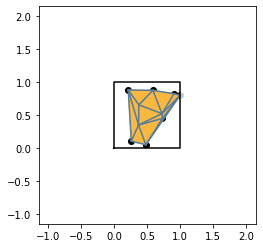

In [19]:
alpha = float("inf")
N = 10

points = gen_points(N=N)
plot_complex(points, alpha=alpha)

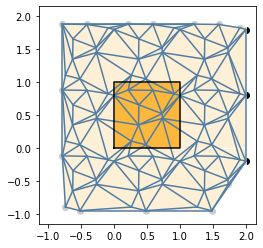

In [20]:
extended_points = torus_copy(points)
plot_complex(extended_points, alpha=alpha)

dim C_0 = 10
dim Z_0 = 10
dim B_0 = 9
dim H_0 = 1


dim C_1 = 30
dim Z_1 = 21
dim B_1 = 19
dim H_1 = 2


dim C_2 = 20
dim Z_2 = 1
dim B_2 = 0
dim H_2 = 1


[(0, (0, inf)), (0, (8, 10)), (0, (7, 11)), (0, (1, 12)), (0, (9, 13)), (0, (4, 14)), (0, (5, 15)), (0, (2, 16)), (0, (6, 17)), (0, (3, 23)), (1, (19, inf)), (1, (22, inf)), (1, (20, 40)), (1, (21, 41)), (1, (24, 42)), (1, (18, 43)), (1, (28, 44)), (1, (29, 45)), (1, (27, 46)), (1, (26, 47)), (1, (30, 48)), (1, (25, 49)), (1, (31, 50)), (1, (32, 51)), (1, (33, 52)), (1, (34, 53)), (1, (35, 54)), (1, (37, 55)), (1, (39, 56)), (1, (38, 57)), (1, (36, 58)), (2, (59, inf))]


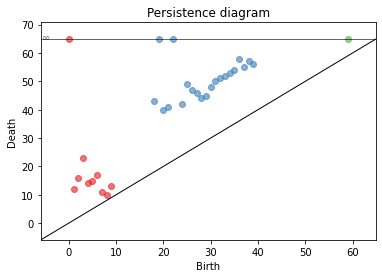

In [25]:
p_filt = periodic_filtration(N, extended_points, alpha=alpha)
D1, D2, D3 = boundary_matrix(p_filt)
PH(D1, D2, D3)